In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler,TensorDataset
import torch.nn.functional as F

from model import Discriminator

import matplotlib.pyplot as plt
import os
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [3]:
batch_size = 128

data = pickle.load(open('datalist.p','rb'))
train_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [4]:
from model import Generator

IMG_SIZE = 64
IMAGE_DIM = IMG_SIZE**2

# Hyperparameters
latent_dim = 100
lr = 0.0002

kernel_size = 6
stride = 2
padding = 1
img_channel = 3

generator = Generator(latent_dim,IMG_SIZE*2,img_channel,kernel_size,stride,padding).to(device)

z = torch.randn(32, latent_dim,1,1).to(device)
fake_images = generator(z,debug= True)

input dim: torch.Size([32, 100, 1, 1])
layer1 dim: torch.Size([32, 1024, 4, 4])
layer2 dim: torch.Size([32, 512, 8, 8])
layer3 dim: torch.Size([32, 256, 15, 15])
layer4 dim: torch.Size([32, 128, 31, 31])
final layer dim: torch.Size([32, 3, 64, 64])


In [5]:
print(f"Allocated GPU Memory: {torch.cuda.memory_stats(device=device)['allocated_bytes.all.current'] / 1024**3:.2f} GB")
        

Allocated GPU Memory: 0.19 GB


In [6]:
discriminator = Discriminator(3).to(device)

In [7]:
print(f"Allocated GPU Memory: {torch.cuda.memory_stats(device=device)['allocated_bytes.all.current'] / 1024**3:.2f} GB")
        

Allocated GPU Memory: 0.21 GB


In [8]:
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

In [9]:
criterion = nn.BCELoss()

In [10]:
for batch_idx, real_images in enumerate(train_loader):
    real_images = real_images.permute(0, 3, 1, 2).to(device)
    a=discriminator(real_images.to(device))
    
    break

In [17]:
repeats = 3

Epoch [1/100], Batch [0/45], Discriminator Loss: 0.3674, Generator Loss: 3.5003, GPU Memory: 0.85 GB
Epoch [2/100], Batch [0/45], Discriminator Loss: 0.3838, Generator Loss: 3.3920, GPU Memory: 0.85 GB
Epoch [3/100], Batch [0/45], Discriminator Loss: 0.3062, Generator Loss: 4.3398, GPU Memory: 0.85 GB
Epoch [4/100], Batch [0/45], Discriminator Loss: 0.2757, Generator Loss: 3.7238, GPU Memory: 0.85 GB
Epoch [5/100], Batch [0/45], Discriminator Loss: 0.2957, Generator Loss: 3.6411, GPU Memory: 0.85 GB
Epoch [6/100], Batch [0/45], Discriminator Loss: 0.3274, Generator Loss: 3.5330, GPU Memory: 0.85 GB
Epoch [7/100], Batch [0/45], Discriminator Loss: 0.2971, Generator Loss: 3.8503, GPU Memory: 0.85 GB
Epoch [8/100], Batch [0/45], Discriminator Loss: 0.3934, Generator Loss: 3.5112, GPU Memory: 0.85 GB
Epoch [9/100], Batch [0/45], Discriminator Loss: 0.2291, Generator Loss: 3.6520, GPU Memory: 0.85 GB
Epoch [10/100], Batch [0/45], Discriminator Loss: 0.2386, Generator Loss: 3.3072, GPU Memor

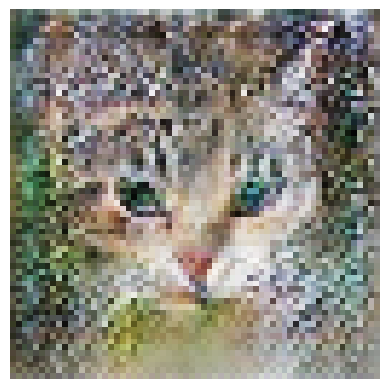

In [18]:
num_epochs = 100



save_training_images = True

if save_training_images:
    os.makedirs('images/{}'.format(repeats),exist_ok=True)
    
    


generator.train()
discriminator.train()


for epoch in range(num_epochs):
    
    count = 0
    
    for batch_idx, real_images in enumerate(train_loader):
        
        

        
        image_len = real_images.shape[0]
        
        
        real_labels = torch.ones(image_len, 1).to(device)
        fake_labels = torch.zeros(image_len, 1).to(device)
        
        
        real_images = real_images.permute(0, 3, 1, 2).to(device)
        
        
        
        
        z = torch.randn(image_len, latent_dim,1,1).to(device)
        fake_images = generator(z)
        fake_images=fake_images.to(device)

        
        #discriminator
        discriminator_real_loss = criterion(discriminator(real_images.to(device)).to(device), real_labels)
        
        discriminator_fake_loss = criterion(discriminator(fake_images.detach()).to(device), fake_labels)
        
        discriminator_loss = discriminator_real_loss + discriminator_fake_loss
        
        
        
        
        discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
    
        
        #generator
        
        z = torch.randn(image_len, latent_dim,1,1).to(device)
        fake_images = generator(z).to(device)
        generator_loss = criterion(discriminator(fake_images).to(device), real_labels)
        
        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()  
        
        

        if count % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], "
                  f"Discriminator Loss: {discriminator_loss:.4f}, Generator Loss: {generator_loss:.4f}, "
                  f"GPU Memory: {torch.cuda.memory_stats(device=device)['allocated_bytes.all.current'] / 1024**3:.2f} GB")

            sample_image = fake_images[0].permute(1, 2, 0)
            numpy_image = sample_image.cpu().detach().numpy()
            if save_training_images:
            
                plt.imshow(numpy_image)
                plt.axis('off')
                plt.savefig('.//images//{}//Epoch{}_Batch{}_{}.png'.format(repeats,epoch,batch_idx,len(train_loader)), bbox_inches='tight', pad_inches=0)
        count+=1

        
    torch.cuda.empty_cache()
        
        
        

In [12]:
os.makedirs("models",exist_ok=True)

torch.save(discriminator.state_dict(), 'models/discriminator.pth')
torch.save(generator.state_dict(), 'models/generator.pth')